In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

import warnings

warnings.filterwarnings("ignore")
%matplotlib inline




In [2]:
DATA_PATH = "data/v2.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,Date,values
0,2015-11-23,2089.409912
1,2015-11-24,2084.419922
2,2015-11-25,2089.300049
3,2015-11-26,2089.300049
4,2015-11-27,2088.820068


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1825 non-null   object 
 1   values  1825 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.6+ KB


In [4]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")

# задаём частоту "1 день"
df = df.asfreq("D")

df.head(), df.tail()


(                 values
 Date                   
 2015-11-23  2089.409912
 2015-11-24  2084.419922
 2015-11-25  2089.300049
 2015-11-26  2089.300049
 2015-11-27  2088.820068,
                  values
 Date                   
 2020-11-16  3600.159912
 2020-11-17  3610.310059
 2020-11-18  3612.090088
 2020-11-19  3559.409912
 2020-11-20  3579.310059)

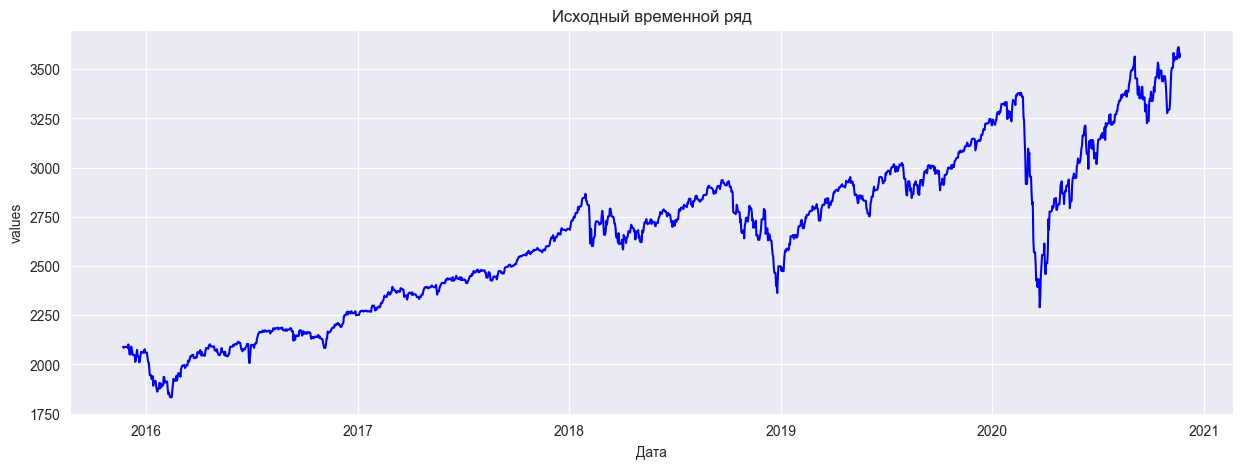

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(df.index, df["values"], color="blue")
plt.title("Исходный временной ряд")
plt.xlabel("Дата")
plt.ylabel("values")
plt.grid(True)
plt.show()


In [6]:
df["year"] = df.index.year
df["month"] = df.index.month
df["dayofweek"] = df.index.dayofweek

df.head()


,values,year,month,dayofweek
Date,,,,
2015-11-23,2089.409912,2015,11,0
2015-11-24,2084.419922,2015,11,1
2015-11-25,2089.300049,2015,11,2
2015-11-26,2089.300049,2015,11,3
2015-11-27,2088.820068,2015,11,4


In [7]:
df_pivot = pd.pivot_table(
    df,
    values="values",
    index="month",
    columns="year"
)

df_pivot.head()


year,2015,2016,2017,2018,2019,2020
month,,,,,,
1,NaN,1933.377111,2273.300624,2782.642893,2595.109052,3280.052278
2,NaN,1902.269641,2326.008231,2711.769270,2745.861459,3290.842075
3,NaN,2016.150962,2368.165157,2700.388373,2803.247755,2655.194509
4,NaN,2073.395703,2360.281673,2660.212655,2901.770353,2753.391300
5,NaN,2064.267413,2394.651627,2699.176797,2858.606776,2919.494849


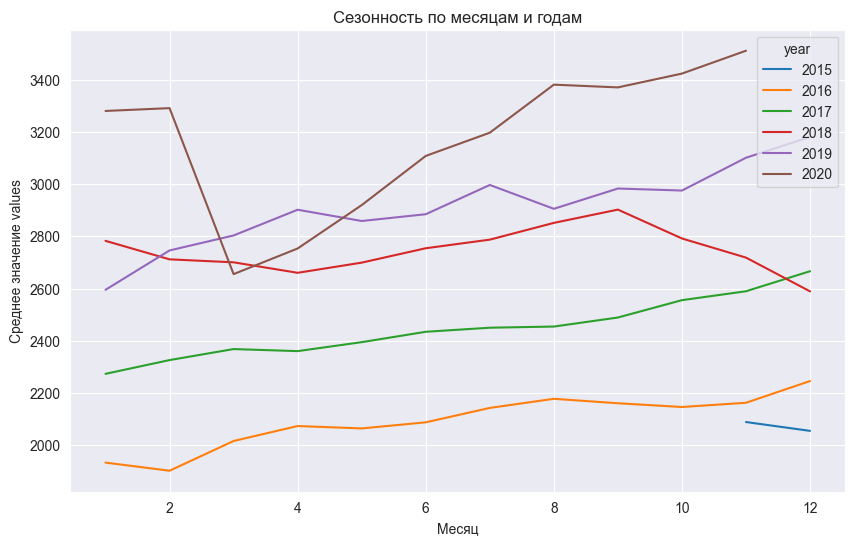

In [8]:
df_pivot.plot(figsize=(10, 6), title="Сезонность по месяцам и годам")
plt.xlabel("Месяц")
plt.ylabel("Среднее значение values")
plt.grid(True)
plt.show()


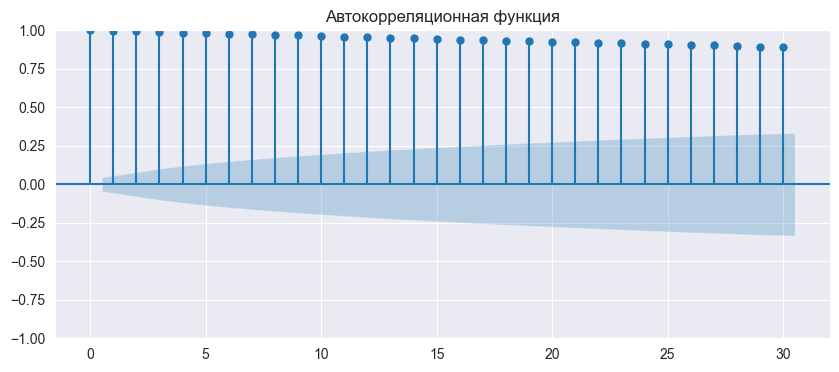

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df["values"].values, lags=30, ax=ax)
plt.title("Автокорреляционная функция")
plt.show()


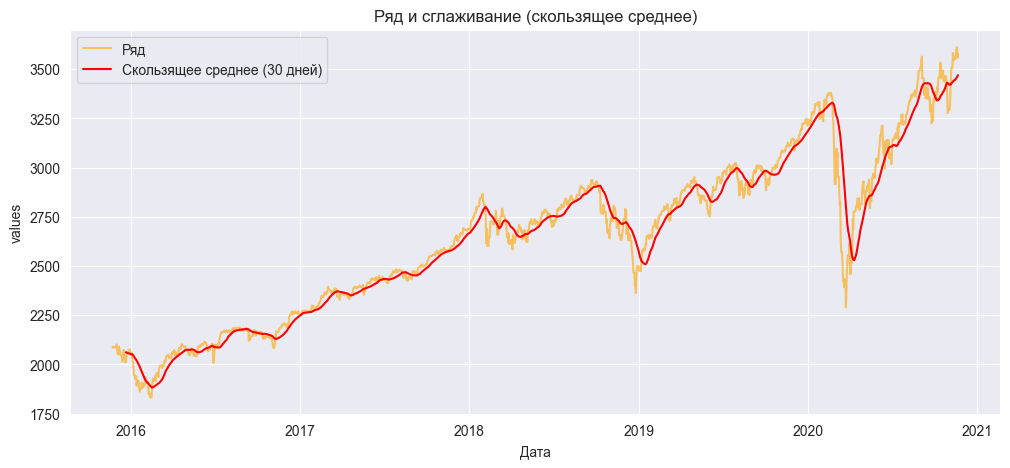

In [10]:
plt.figure(figsize=(12, 5))

rolling_mean = df["values"].rolling(window=30).mean()

plt.plot(df.index, df["values"], label="Ряд", color="orange", alpha=0.6)
plt.plot(df.index, rolling_mean, label="Скользящее среднее (30 дней)", color="red")
plt.title("Ряд и сглаживание (скользящее среднее)")
plt.xlabel("Дата")
plt.ylabel("values")
plt.legend(loc="best")
plt.grid(True)
plt.show()


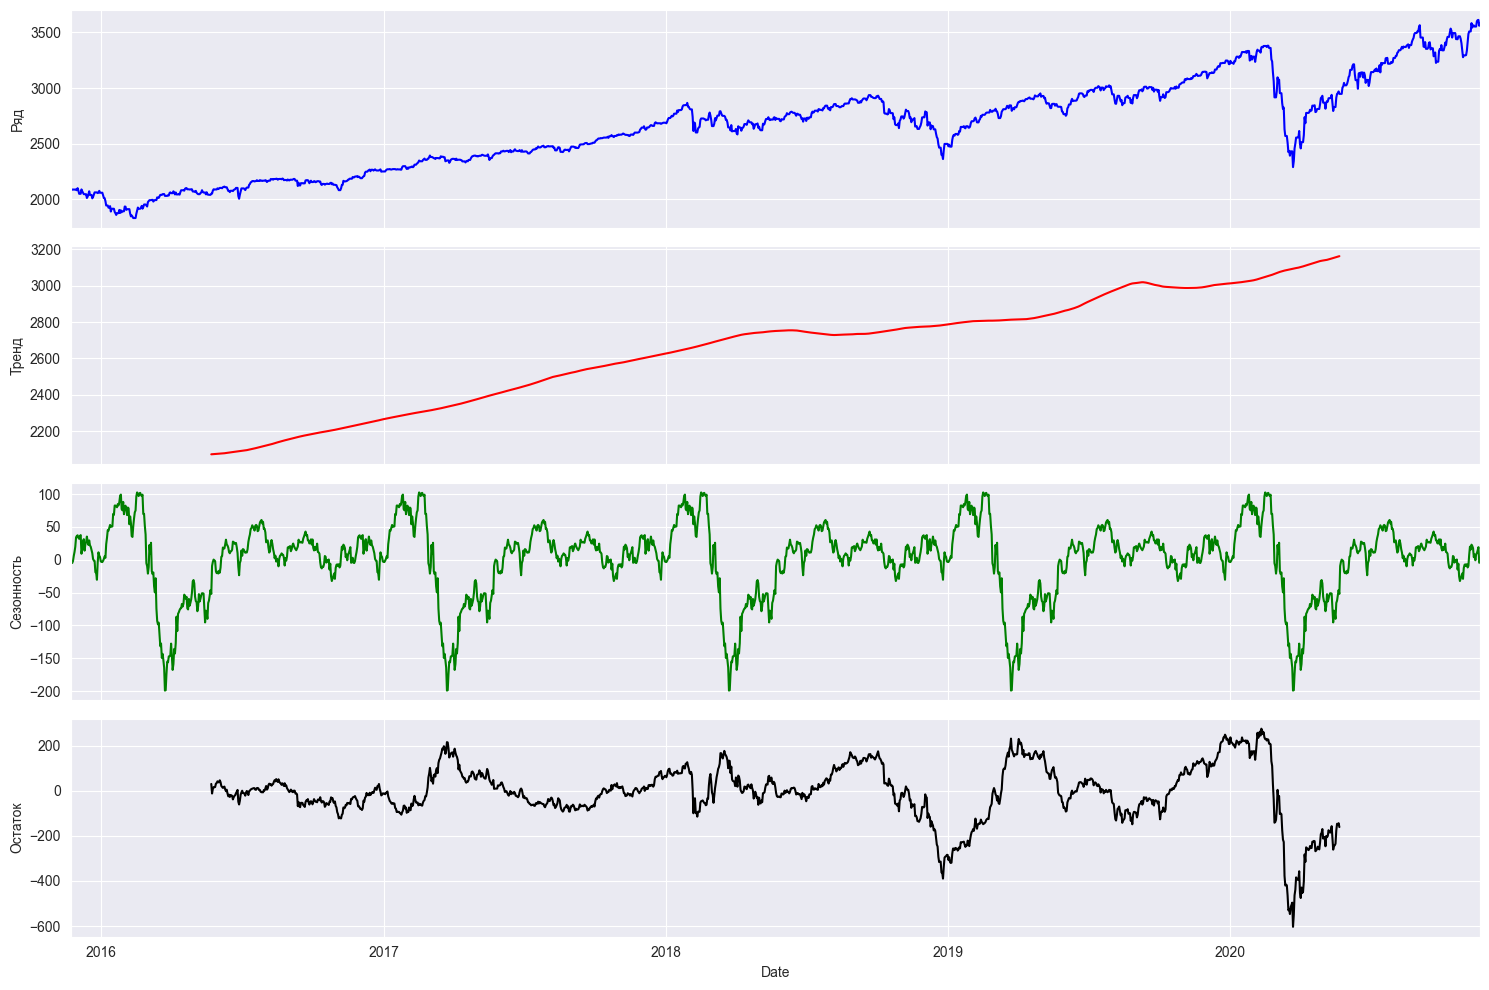

In [11]:
plt.rcParams["figure.figsize"] = (15, 10)

res = sm.tsa.seasonal_decompose(
    df["values"],
    model="additive",
    period=365
)

fig, axes = plt.subplots(4, 1, sharex=True)

res.observed.plot(ax=axes[0], legend=False, color="blue")
axes[0].set_ylabel("Ряд")

res.trend.plot(ax=axes[1], legend=False, color="red")
axes[1].set_ylabel("Тренд")

res.seasonal.plot(ax=axes[2], legend=False, color="green")
axes[2].set_ylabel("Сезонность")

res.resid.plot(ax=axes[3], legend=False, color="black")
axes[3].set_ylabel("Остаток")

plt.tight_layout()
plt.show()


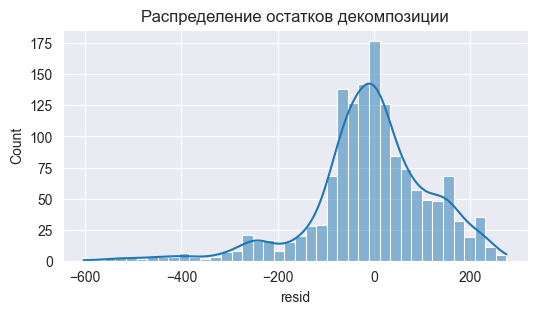

In [12]:
plt.figure(figsize=(6, 3))
sns.histplot(res.resid.dropna(), kde=True)
plt.title("Распределение остатков декомпозиции")
plt.xlabel("resid")
plt.grid(True)
plt.show()


In [13]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.api import ExponentialSmoothing

series = df["values"].astype(float)

horizon = 24  # последние 24 значения

train = series.iloc[:-horizon]
test = series.iloc[-horizon:]

print(len(series), len(train), len(test))


1825 1801 24


In [14]:
def evaluate_forecast(y_true, y_pred, prefix=""):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(prefix)
    print(f"  RMSE = {rmse:.4f}")
    print(f"  MAE  = {mae:.4f}")
    print(f"  MAPE = {mape:.4f}")
    print()

    return {"rmse": rmse, "mae": mae, "mape": mape}


In [15]:
model_es = ExponentialSmoothing(
    np.asarray(train),
    trend="add",
    seasonal="add",
    seasonal_periods=365
).fit()

forecast_es = model_es.forecast(horizon)
forecast_es = pd.Series(forecast_es, index=test.index)

metrics_es_holdout = evaluate_forecast(test.values, forecast_es.values, prefix="ExponentialSmoothing (holdout)")


ExponentialSmoothing (holdout)
  RMSE = 114.5661
  MAE  = 108.0218
  MAPE = 0.0310



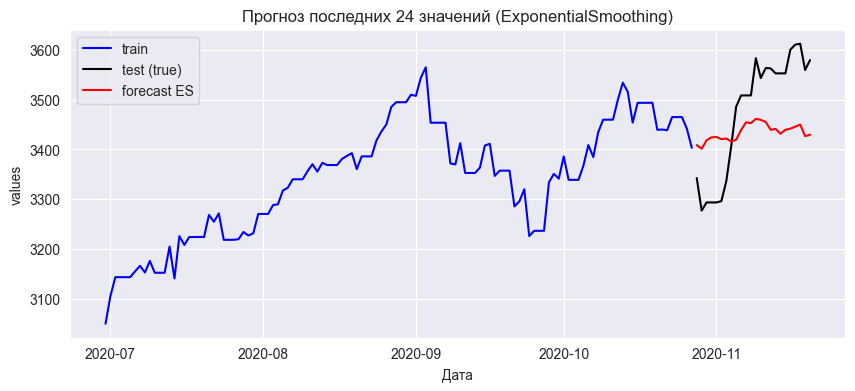

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(train.index[-5 * horizon:], train.values[-5 * horizon:], label="train", color="blue")
plt.plot(test.index, test.values, label="test (true)", color="black")
plt.plot(forecast_es.index, forecast_es.values, label="forecast ES", color="red")
plt.title("Прогноз последних 24 значений (ExponentialSmoothing)")
plt.xlabel("Дата")
plt.ylabel("values")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

cv_results_es = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(series), start=1):
    train_cv = series.iloc[train_idx]
    test_cv = series.iloc[test_idx]

    # модель может требовать, чтобы train_cv был существенно длиннее периодов
    model_cv = ExponentialSmoothing(
        np.asarray(train_cv),
        trend="add",
        seasonal="add",
        seasonal_periods=7
    ).fit()

    forecast_cv = model_cv.forecast(len(test_cv))
    forecast_cv = np.asarray(forecast_cv)

    print(f"Fold {fold}: len_train={len(train_cv)}, len_test={len(test_cv)}")
    metrics_fold = evaluate_forecast(test_cv.values, forecast_cv, prefix=f"Fold {fold}")
    cv_results_es.append(metrics_fold)


Fold 1: len_train=305, len_test=304
Fold 1
  RMSE = 128.3752
  MAE  = 110.7178
  MAPE = 0.0469

Fold 2: len_train=609, len_test=304
Fold 2
  RMSE = 96.8815
  MAE  = 71.7965
  MAPE = 0.0266

Fold 3: len_train=913, len_test=304
Fold 3
  RMSE = 159.9019
  MAE  = 125.6110
  MAPE = 0.0469

Fold 4: len_train=1217, len_test=304
Fold 4
  RMSE = 102.4796
  MAE  = 77.1148
  MAPE = 0.0250

Fold 5: len_train=1521, len_test=304
Fold 5
  RMSE = 390.4830
  MAE  = 297.0582
  MAPE = 0.1034



In [18]:
rmse_mean = np.mean([m["rmse"] for m in cv_results_es])
mae_mean = np.mean([m["mae"] for m in cv_results_es])
mape_mean = np.mean([m["mape"] for m in cv_results_es])

print("ExponentialSmoothing (TimeSeriesSplit CV):")
print(f"  RMSE (mean) = {rmse_mean:.4f}")
print(f"  MAE  (mean) = {mae_mean:.4f}")
print(f"  MAPE (mean) = {mape_mean:.4f}")


ExponentialSmoothing (TimeSeriesSplit CV):
  RMSE (mean) = 175.6242
  MAE  (mean) = 136.4597
  MAPE (mean) = 0.0498


In [19]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

series = df["values"].astype(float)  # тот же ряд, что и раньше


def make_supervised_series(series, n_lags=7, add_calendar=True, add_rolling=True):
    """
    Строит выборку для регрессии:
    X_t = [y_{t-1}, ..., y_{t-n_lags}, доп. признаки],  y_t = y_t.
    """
    data = pd.DataFrame({"y": series})

    # лаги
    for lag in range(1, n_lags + 1):
        data[f"lag_{lag}"] = data["y"].shift(lag)

    # скользящее среднее по прошлым значениям
    if add_rolling:
        data["roll_mean_7"] = data["y"].shift(1).rolling(window=7).mean()

    # календарные признаки (по индексу)
    if add_calendar:
        idx = series.index
        data["month"] = idx.month
        data["dayofweek"] = idx.dayofweek

    # удаляем строки с NaN (первые n_lags и окно rolling)
    data = data.dropna()

    X = data.drop(columns=["y"])
    y = data["y"]

    return X, y, data


n_lags = 7
X_reg, y_reg, df_reg = make_supervised_series(series, n_lags=n_lags)

X_reg.shape, y_reg.shape


((1818, 10), (1818,))

In [20]:
horizon = 24

X_train_reg = X_reg.iloc[:-horizon]
y_train_reg = y_reg.iloc[:-horizon]

X_test_reg = X_reg.iloc[-horizon:]
y_test_reg = y_reg.iloc[-horizon:]

reg = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

reg.fit(X_train_reg, y_train_reg)
y_pred_reg = reg.predict(X_test_reg)

metrics_reg_holdout = evaluate_forecast(
    y_test_reg.values,
    y_pred_reg,
    prefix="RandomForestRegressor (holdout)"
)


RandomForestRegressor (holdout)
  RMSE = 69.7591
  MAE  = 58.5967
  MAPE = 0.0167



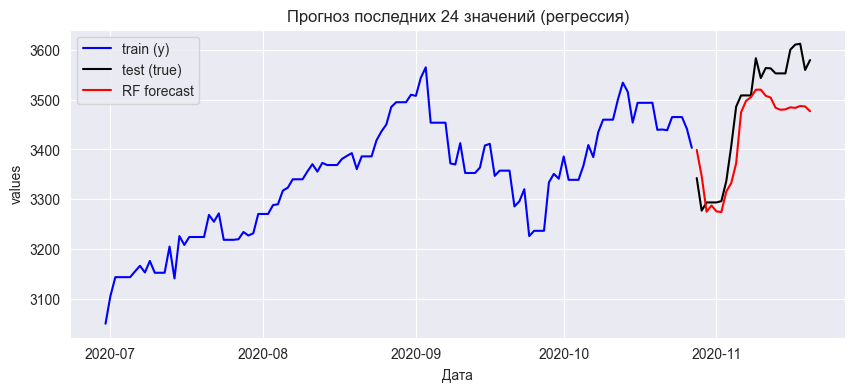

In [21]:
plt.figure(figsize=(10, 4))

# последние несколько дней train для контекста
context_len = 5 * horizon
context_start = max(0, len(y_reg) - horizon - context_len)

plt.plot(
    df_reg.index[context_start:-horizon],
    y_reg.iloc[context_start:-horizon],
    label="train (y)",
    color="blue"
)
plt.plot(
    df_reg.index[-horizon:],
    y_test_reg.values,
    label="test (true)",
    color="black"
)
plt.plot(
    df_reg.index[-horizon:],
    y_pred_reg,
    label="RF forecast",
    color="red"
)

plt.title("Прогноз последних 24 значений (регрессия)")
plt.xlabel("Дата")
plt.ylabel("values")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
tscv_reg = TimeSeriesSplit(n_splits=5)

cv_results_reg = []

for fold, (train_idx, test_idx) in enumerate(tscv_reg.split(X_reg), start=1):
    X_tr, X_te = X_reg.iloc[train_idx], X_reg.iloc[test_idx]
    y_tr, y_te = y_reg.iloc[train_idx], y_reg.iloc[test_idx]

    model_cv = RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )

    model_cv.fit(X_tr, y_tr)
    y_pred_cv = model_cv.predict(X_te)

    print(f"RF-reg Fold {fold}: len_train={len(X_tr)}, len_test={len(X_te)}")
    metrics_fold = evaluate_forecast(
        y_te.values,
        y_pred_cv,
        prefix=f"RF-reg Fold {fold}"
    )
    cv_results_reg.append(metrics_fold)


RF-reg Fold 1: len_train=303, len_test=303
RF-reg Fold 1
  RMSE = 170.0395
  MAE  = 143.2998
  MAPE = 0.0603

RF-reg Fold 2: len_train=606, len_test=303
RF-reg Fold 2
  RMSE = 182.8582
  MAE  = 152.5374
  MAPE = 0.0566

RF-reg Fold 3: len_train=909, len_test=303
RF-reg Fold 3
  RMSE = 38.6364
  MAE  = 26.7169
  MAPE = 0.0097

RF-reg Fold 4: len_train=1212, len_test=303
RF-reg Fold 4
  RMSE = 147.0964
  MAE  = 97.6788
  MAPE = 0.0312

RF-reg Fold 5: len_train=1515, len_test=303
RF-reg Fold 5
  RMSE = 90.1286
  MAE  = 62.6798
  MAPE = 0.0194



In [23]:
rmse_mean_reg = np.mean([m["rmse"] for m in cv_results_reg])
mae_mean_reg = np.mean([m["mae"] for m in cv_results_reg])
mape_mean_reg = np.mean([m["mape"] for m in cv_results_reg])

print("RandomForestRegressor (TimeSeriesSplit CV):")
print(f"  RMSE (mean) = {rmse_mean_reg:.4f}")
print(f"  MAE  (mean) = {mae_mean_reg:.4f}")
print(f"  MAPE (mean) = {mape_mean_reg:.4f}")


RandomForestRegressor (TimeSeriesSplit CV):
  RMSE (mean) = 125.7518
  MAE  (mean) = 96.5825
  MAPE (mean) = 0.0354
